Завдання:
1. Оберіть ваш варіант та завантажте необхідний файл з даними.
2. Проаналізуйте приклад використання згорткової нейронної мережі 
для класифікації зображень.
3. Змініть архітектуру нейронної мережі (кількість шарів, функції 
активації та інші параметри), а також код (за потреби) та проведіть 
експерименти по класифікації зображень відповідно до варіанту.
Занотуйте результати у звіті.
4. Проаналізуйте приклад використання підходу Transfer Learning для 
класифікації зображень CIFAR-10.
5. Замініть вашу модифіковану архітектуру мережі (пункт 3) на будьяку із доступних моделей та порівняйте результати класифікації на 
зображеннях із вашого варіанту. Чи застосування підходу Transfer 
Learning покращило результати класифікації? Обґрунтуйте результат 
та занотуйте у звіті.
6. Дайте відповіді на контрольні запитання (усно)

In [2]:
import pandas as pd
import numpy as np

# loading data

In [1]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

data_dir = "../data/variant-3/variant-3"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [3]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
from sklearn.model_selection import train_test_split

if os.path.exists(train_dir) and os.path.exists(test_dir):
  train_ds = ImageFolder(root=train_dir, transform=transform)
  test_ds = ImageFolder(root=test_dir, transform=transform)
  class_names = train_ds.classes
else:
  ds = ImageFolder(root=data_dir, transform=transform)
  class_names = ds.classes
  indices = list(range(len(ds)))
  train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
  train_ds = Subset(ds, train_indices)
  test_ds = Subset(ds, test_indices)

In [5]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [9]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2466
    Root location: ../data/variant-3/variant-3\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [11]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 95
    Root location: ../data/variant-3/variant-3\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

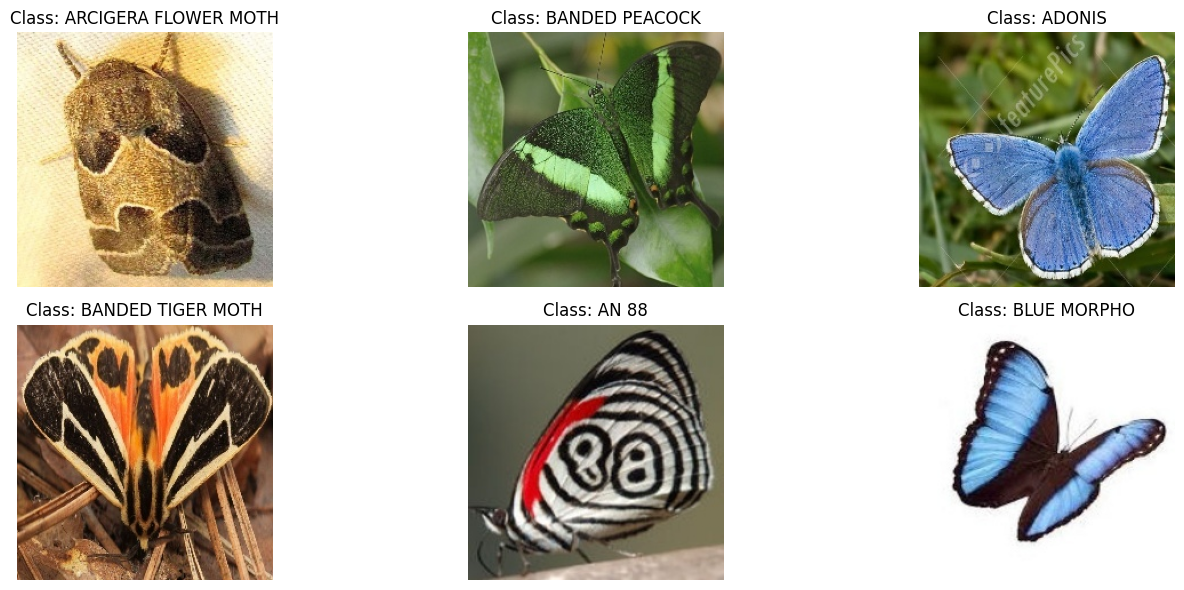

In [6]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

num_of_images = 6
plt.figure(figsize=(15, 6))
for i in range(num_of_images):
  img = images[i].numpy().transpose((1, 2, 0))
  img = np.clip(img * 0.5 + 0.5, 0, 1)
  plt.subplot(2, int(num_of_images/ 2), i + 1)
  plt.imshow(img)
  if class_names:
      plt.title(f'Class: {class_names[labels[i]]}')
  else:
      plt.title(f'Label: {labels[i].item()}')
  plt.axis('off')
plt.tight_layout()
plt.show()

# modeling

In [12]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

https://www.learnpytorch.io/03_pytorch_computer_vision/

The CNN model we're going to be using is known as TinyVGG from the CNN Explainer website.

It follows the typical structure of a convolutional neural network:

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.

In [13]:
images[0].shape

torch.Size([3, 224, 224])

This is because our nn.Conv2d() layer expects a 4-dimensional tensor as input with size (N, C, H, W) or [batch_size, color_channels, height, width].

In [15]:
import torch.nn as nn

class ButterfliesCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int, kernel_size: int = 3):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_shape,
        out_channels=hidden_units,
        kernel_size=kernel_size,
        stride=1, # default
        padding=1,
      ),
      nn.ReLU(),
      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=kernel_size,
        stride=1, # default
        padding=1,
      ),
      nn.ReLU(),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2, # default stride value is same as kernel_size
      )
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(hidden_units, hidden_units, kernel_size=kernel_size, padding=1),
      nn.ReLU(),
      nn.Conv2d(hidden_units, hidden_units, kernel_size=kernel_size, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*56*56, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x
  
model_0 = ButterfliesCNN(
  input_shape=3,
  hidden_units=12,
  output_shape=len(class_names)
).to(device)
model_0

ButterfliesCNN(
  (block_1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37632, out_features=12, bias=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=19, bias=True)
  )
)

Essentially, every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being smaller in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to compress information.

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
  params=model_0.parameters(),
  lr=0.1,
)

In [17]:
def train_model(model, train_loader, criterion, optimizer, device, epochs) -> tuple[list, list]:
  model.train()
  train_losses = []
  train_accs = []
  
  for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct/total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
  return train_losses, train_accs  
  

In [18]:
def evaluate_model(model, test_loader, device) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

In [19]:
torch.manual_seed(42)

train_losses, train_accs = train_model(
  model=model_0,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=3
)

Epoch 1/3, Loss: 2.9516, Accuracy: 0.0608
Epoch 2/3, Loss: 2.9446, Accuracy: 0.0685
Epoch 3/3, Loss: 2.9406, Accuracy: 0.0685


In [20]:
accuracy = evaluate_model(
  model=model_0,
  test_loader=test_loader,
  device=device,
)

Test Accuracy: 0.0526


ну може це моделька погана...

візьмем модельку з методички

In [21]:
class TeachesCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64 * 56 * 56, 128)
    self.fc2 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x
model_1 = TeachesCNN(len(class_names)).to(device)
model_1

TeachesCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
  (relu): ReLU()
)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.001
)

In [23]:
torch.manual_seed(42)

train_losses, train_accs = train_model(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 2.6050, Accuracy: 0.2502
Epoch 2/5, Loss: 1.4962, Accuracy: 0.5592
Epoch 3/5, Loss: 0.9504, Accuracy: 0.7170
Epoch 4/5, Loss: 0.5622, Accuracy: 0.8244
Epoch 5/5, Loss: 0.2848, Accuracy: 0.9140


In [24]:
accuracy = evaluate_model(
  model=model_1,
  test_loader=test_loader,
  device=device,
)

Test Accuracy: 0.6842


ага! хтось перенавчися (я😥)

але загалом, це ліпше, ніж попередня моделька.
тому треба
1. порівняти модельки (мені здається, шо проблема в класифаєрах, в першій модельці їх два шари, в нульовій - тіки один)
2. додати інші метрики, бо ота ек'юресі мені не нравиця

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ScoreDict:
  def __init__(self):
    self.score_dict = {
      "acc" : 0,
      "prec": 0,
      "rec": 0,
      "f1": 0
    }
  def __str__(self):
    return f"\t> acc: {self.score_dict['acc']:.2f},\n\t> prec: {self.score_dict['prec']:.2f},\n\t> rec: {self.score_dict['rec']:.2f},\n\t> f1: {self.score_dict['f1']:.2f}\n\t"
  @staticmethod
  def add_dicts(x: dict, y: dict) -> dict:
    keys = set(x.keys()).intersection(set(y.keys()))
    res_dict = {}
    for key in keys:
      res_dict[key] = x.get(key) + y.get(key)
    return res_dict
  def add_scores(self, y_pred, y_true) -> dict:
    new_scores = {
      "acc": accuracy_score(y_pred, y_true),
      "prec": precision_score(y_pred, y_true, average='macro', zero_division=0),
      "rec": recall_score(y_pred, y_true, average='macro', zero_division=0),
      "f1": f1_score(y_pred, y_true, average='macro')
    }
    self.score_dict = self.add_dicts(self.score_dict, new_scores)
    return self.score_dict 
  def divide_by(self, k: float) -> dict:
    for key, value in self.score_dict.items():
      self.score_dict[key] = value / k
    return self.score_dict
    

поглянем на формат предиктів

In [26]:
images, labels = next(iter(train_loader))
labels.detach().numpy()

array([ 0, 16, 14,  2,  7, 18, 17, 17,  3, 14, 17, 15,  6,  3,  7, 13,  1,
       16,  9, 11, 16,  1,  7, 16,  7,  3, 16,  5,  3,  8, 15,  7],
      dtype=int64)

In [30]:
[torch.argmax(x).item() for x in outputs]

[0,
 16,
 14,
 2,
 7,
 18,
 17,
 17,
 3,
 14,
 17,
 15,
 6,
 3,
 7,
 13,
 1,
 16,
 9,
 11,
 16,
 1,
 7,
 16,
 7,
 3,
 16,
 5,
 3,
 8,
 15,
 7]

In [29]:
outputs = model_1(images.to(device))
torch.argmax(torch.sigmoid(outputs))

tensor(0, device='cuda:0')

In [31]:
def train_model_scores(model, train_loader, criterion, optimizer, device, epochs) -> tuple[list, list]:
  model.train()
  train_losses = []
  train_accs = []
  train_scores = [] # of ScoreDicts
  
  for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    scores = ScoreDict()
    
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      
      y_pred = [torch.argmax(x).item() for x in outputs]
      y_true = labels.cpu().detach().numpy()
      scores.add_scores(y_pred, y_true)
      
      optimizer.step()
      
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
      
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct/total
    scores.divide_by(len(train_loader))
    train_scores.append(scores)
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    print(f"{scores}")
  return train_losses, train_accs, train_scores

додав оцей ScoreDict, надіюсь він працює

In [32]:
model_1 = TeachesCNN(len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.001,
)

In [34]:
torch.manual_seed(42)

train_losses, train_accs, train_scores = train_model_scores(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 0.0123, Accuracy: 1.0000
	> acc: 1.00,
	> prec: 1.00,
	> rec: 1.00,
	> f1: 1.00
	
Epoch 2/5, Loss: 0.0030, Accuracy: 1.0000
	> acc: 1.00,
	> prec: 1.00,
	> rec: 1.00,
	> f1: 1.00
	
Epoch 3/5, Loss: 0.0013, Accuracy: 1.0000
	> acc: 1.00,
	> prec: 1.00,
	> rec: 1.00,
	> f1: 1.00
	
Epoch 4/5, Loss: 0.0009, Accuracy: 1.0000
	> acc: 1.00,
	> prec: 1.00,
	> rec: 1.00,
	> f1: 1.00
	
Epoch 5/5, Loss: 0.0007, Accuracy: 1.0000
	> acc: 1.00,
	> prec: 1.00,
	> rec: 1.00,
	> f1: 1.00
	


In [46]:
print(train_scores[1])

	> acc: 1.00,
	> prec: 1.00,
	> rec: 1.00,
	> f1: 1.00
	


воно навчається набагато довше ніж без тих метрик, напевно перекидати тензори з cpu на gpu не так і швидко. тому заберемо це в навчанні, закинем в eval, а в навчаня замість того закинем валідацію

я забув додати оці scores в ретурн😭😭😭
перед парою перезапущу

In [175]:
def train_model_validation(model, train_loader, criterion, optimizer, device, epochs) -> tuple[list, list]:
  train_losses, train_accs = [], []
  test_losses, test_accs = [], []
  
  for epoch in range(epochs):
    model.train()
    
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct/total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # отутечки додаєм
    val_loss, val_correct, val_total = 0, 0, 0
    model.eval()
    with torch.inference_mode():
      for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        val_outputs = model(X)
        val_loss += criterion(val_outputs, y).item()
        
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct += (val_predicted == y).sum().item()
        val_total += y.size(0)
      val_loss = val_loss / len(test_loader)
      val_acc = val_correct / val_total
      test_losses.append(val_loss)
      test_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} || Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
  return train_losses, train_accs, test_losses, test_accs
  

In [186]:
model_1 = TeachesCNN(len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.01,
)

In [187]:
train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 7.5869, Accuracy: 0.0572 || Validation Loss: 2.9493, Accuracy: 0.0526
Epoch 2/5, Loss: 2.9399, Accuracy: 0.0572 || Validation Loss: 2.9497, Accuracy: 0.0526
Epoch 3/5, Loss: 2.9405, Accuracy: 0.0649 || Validation Loss: 2.9514, Accuracy: 0.0526
Epoch 4/5, Loss: 2.9399, Accuracy: 0.0657 || Validation Loss: 2.9510, Accuracy: 0.0526
Epoch 5/5, Loss: 2.9392, Accuracy: 0.0620 || Validation Loss: 2.9518, Accuracy: 0.0526


надто довго вчилась

In [180]:
model_1 = TeachesCNN(len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.001,
)

In [184]:
train_losses, train_accs = train_model(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 2.7903, Accuracy: 0.2364
Epoch 2/5, Loss: 1.5781, Accuracy: 0.5349
Epoch 3/5, Loss: 1.0440, Accuracy: 0.6845
Epoch 4/5, Loss: 0.5913, Accuracy: 0.8224
Epoch 5/5, Loss: 0.2819, Accuracy: 0.9161


In [185]:
accuracy = evaluate_model(
  model=model_1,
  test_loader=test_loader,
  device=device,
)

Test Accuracy: 0.6632


In [199]:
def visualize_predictions(model, dataloader, device, class_names=None, num_images=5):
  model.eval()
  images, labels = next(iter(dataloader))
  with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

  plt.figure(figsize=(15, 3))
  for i in range(num_images):
    img = images[i].numpy().transpose((1, 2, 0))
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    if class_names:
      true_label = class_names[labels[i]]
      pred_label = class_names[predicted[i]]
      color = 'green' if labels[i] == predicted[i] else 'red'
      plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    else:
      color = 'green' if labels[i] == predicted[i] else 'red'
      plt.title(f'True: {labels[i]}\nPred: {predicted[i]}', color=color)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

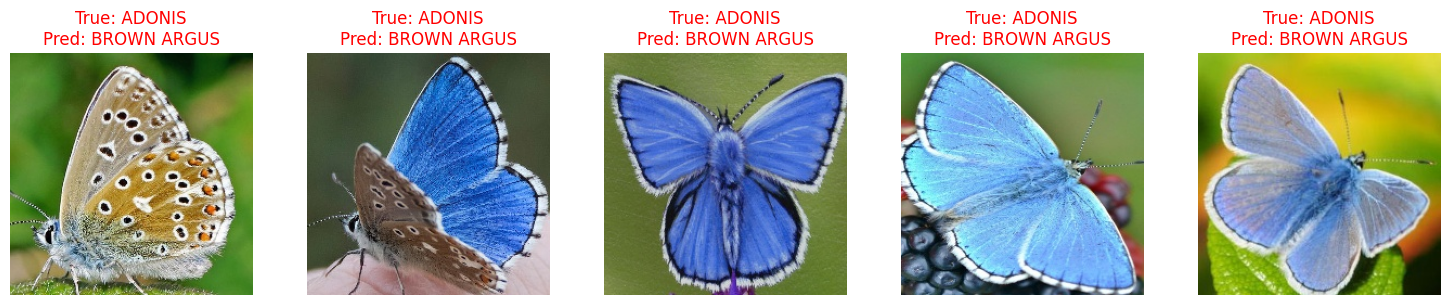

In [201]:
visualize_predictions(model_1, test_loader, device, class_names)

ващє мімо

робим нову модельку, з багатьма класифікаційними шарами🥵

In [188]:
class ButterfliesCNN_V2(nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, x: torch.Tensor):
    pass